In [1]:
import numpy as np
import PIL.Image as Image
import os
import pickle
from feature_vector_extractor import feature_vector_extractor as FVE
from feature_vector_extractor import ConvnetModel

In [2]:
train_pos_path = "./MURA_Torch_Format/train/positive"
train_neg_path = "./MURA_Torch_Format/train/negative"
valid_pos_path = "./MURA_Torch_Format/valid/positive"
valid_neg_path = "./MURA_Torch_Format/valid/negative"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
def img_resize(img):
    '''Resize the image to (w, 299) or (299, h).'''
    
    w, h = img.size
    if w > h:
        ratio = 299 / h
    else:
        ratio = 299 / w
    new_w = round(ratio * w)
    new_h = round(ratio * h)
    return img.resize((new_w, new_h))

In [4]:
def generate_image_list(img, batch_size=48):
    '''
    Take in a image with shape (w, 299) or (299, h), and crop it by (299, 299).
    Retuen a list containing several sub-lists.
    Each sub-list contains several (299, 299) cropped images.
    The size of each sub-list is no more than batch_size.
    '''
    
    img_np = np.asarray(img)
    h, w, c = img_np.shape
    lst = []
    if w == 299:
        limit = h - w
        for shift in range(0, limit + 1, 5):
            img_cropped = img_np[shift:shift+299, :, :]
            lst.append(img_cropped)
    elif h == 299:
        limit = w - h
        for shift in range(0, limit + 1, 5):
            img_cropped = img_np[:, shift:shift+299, :]
            lst.append(img_cropped)
    else:
        raise ValueError('Image must be of shape W x 299 or 299 x H !')
    
    ret_lst = []
    tmp_lst = []
    for idx, ar in enumerate(lst):
        if idx % batch_size == batch_size - 1:
            ret_lst.append(tmp_lst)
            tmp_lst = []
        else:
            tmp_lst.append(ar)
    if tmp_lst:
        ret_lst.append(tmp_lst)
    return ret_lst

In [5]:
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [6]:
def cosine(vec, matrix):
    '''Calculate cosine between the input vector and row vectors stored in matrix.'''
    
    dot_product = np.dot(matrix, vec)
    vec_norm = np.linalg.norm(vec)
    matrix_norm = np.linalg.norm(matrix, axis=1)
    return dot_product / vec_norm / matrix_norm

In [7]:
def predict_similar(vec, mean, std, zero_entry, pos_matrix, neg_matrix, pos_dict, neg_dict):
    '''Given a feature vector of an image, search through the training data set to find the most similar image.'''
    
    pos_matrix *= (1 - zero_entry)
    neg_matrix *= (1 - zero_entry)
    
    mean = mean.reshape((1536,))
    std = std.reshape((1536,))
    zero_entry = zero_entry.reshape((1536,))
    
    vec = ((vec - mean) / std) * (1 - zero_entry)
    
    opt_cos = -2
    opt_ref_vec = None
    opt_class = None
    
    cos_matrix = cosine(vec, pos_matrix)
    max_idx_pos = np.argmax(cos_matrix)
    max_cos_pos = cos_matrix[max_idx_pos]
    
    cos_matrix = cosine(vec, neg_matrix)
    max_idx_neg = np.argmax(cos_matrix)
    max_cos_neg = cos_matrix[max_idx_neg]
    
    if max_cos_pos > max_cos_neg:
        for idx, key in enumerate(pos_dict.keys()):
            if idx == max_idx_pos:
                opt_ref_vec = key
                opt_cos = max_cos_pos
                opt_class = "positive"
    else:
        for idx, key in enumerate(neg_dict.keys()):
            if idx == max_idx_neg:
                opt_ref_vec = key
                opt_cos = max_cos_neg
                opt_class = "negative"
    
    if opt_class == "positive":
        return pos_dict[opt_ref_vec], opt_cos
    else:
        return neg_dict[opt_ref_vec], opt_cos

In [8]:
def most_similar(nearest_lst):
    '''Use the result of mutiple cropped test image to decide the most similar training image to the test image.'''
    
    # Sort result by cosine value.
    nearest_lst.sort(key=lambda x:x[1], reverse=True)
    
    # Count time of occurance.
    occur_dict = {}
    max_occur_time = 0
    max_occur_name = []
    for name, cos in nearest_lst:
        tup = occur_dict.get(name)
        if tup is None:
            occur_dict[name] = (1, cos)
            occur_time = 1
        else:
            occur_time, tmp_max_cos = tup
            occur_time = occur_time + 1
            tmp_max_cos = max(tmp_max_cos, cos)
            occur_dict[name] = (occur_time, tmp_max_cos)
        if occur_time > max_occur_time:
            max_occur_name = [name]
            max_occur_time = occur_time
        elif occur_time == max_occur_time:
            max_occur_name.append(name)
    
    # Find the image with maximal occurance time along with relative maximal cosine value.
    res_name = max_occur_name[0]
    res_cos = occur_dict[res_name][1]
    for name in max_occur_name:
        if occur_dict[name][1] > res_cos:
            res_cos = occur_dict[name][1]
            res_name = name
    
    return res_name

In [9]:
# Load dictionary.
pos_lst = load_obj("pos_norm_dic_lst")
neg_lst = load_obj("neg_norm_dic_lst")
property_dict = load_obj("property_dic")

mean = property_dict["mean"]
std = property_dict["std"]
zero_entry = property_dict["zero"]
pos_dict = dict(pos_lst)
neg_dict = dict(neg_lst)
pos_matrix = np.array([k for k in pos_dict.keys()])
neg_matrix = np.array([k for k in neg_dict.keys()])

In [10]:
# Load a test sample image.
img_dir_lst = os.listdir(valid_pos_path)
path = os.path.join(valid_pos_path, img_dir_lst[23])

In [11]:
# Run a test.
net = ConvnetModel("m-20180518-024519-A.pth.tar")
img = Image.open(path)
img = img.convert('RGB')
img = img_resize(img)
img_lst = generate_image_list(img)
ret_lst = []
for sub_lst in img_lst:
    vec_lst = FVE(sub_lst, net=net, gpu=False)
    for i in vec_lst:
        ret_lst.append(i)

In [12]:
# Find the most similar training sample for every 299x299 crop.
nearest_lst = []
for i in ret_lst:
    nearest_lst.append(predict_similar(i, mean, std, zero_entry, pos_matrix, neg_matrix, pos_dict, neg_dict))

In [13]:
# Find best matching among all crops.
similar_image_name = most_similar(nearest_lst)
sim_path = os.path.join(train_pos_path, similar_image_name)
sim_img = Image.open(sim_path)

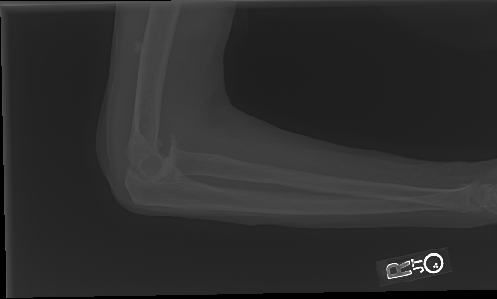

In [14]:
# show test image
img

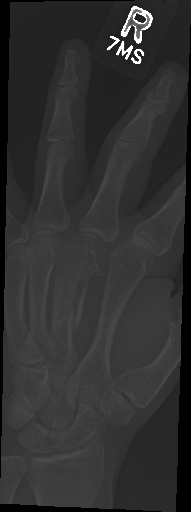

In [15]:
# show the most similar image
sim_img